## News Topic Classification using Transformer

Approach: Fine Tune only the final layer/ Head of Transformer Model


This approach is often used when the task for which the transformer model is being fine-tuned is different from the task for which it was pre-trained. ie only update the final layer to make predictions for the new task.


1. Read DATASET
2. Clean Text data
3. Prepare Tokenizer
4. Initialize Model
5. Train Model
6. Evaluate Model

Run below cells if those libraries not installed yet

In [6]:
# !pip install Datasets evaluate
# !pip install transformers[torch]
# !pip install torchinfo

In [7]:
# dependencies
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments,Trainer
import evaluate
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

### Read Dataset

In [9]:
# # load dataset from GoogleDrive
# train_df = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')
# # load dataset from GoogleDrive
# train_df = pd.read_csv('/content/drive/MyDrive/Fractal/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Fractal/test.csv')

In [10]:
train_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')

In [11]:
# Understand the number of rows and columns for both train and test dataset
train_df.shape, test_df.shape

((120000, 3), (7600, 3))

In [12]:
# In order to reduce the computational time, we are using a sample (30%) of the train dataset (~36K)
train_df = train_df.sample(frac=0.3)

In [13]:
# Lets visualize the sample of dataset
train_df.head()

,Class Index,Title,Description
89405,2,Chiefs' Holmes Doubtful for Sunday,"KANSAS CITY, Mo. (Sports Network) - Kansas Ci..."
112384,2,"Notre Dame Eyes Clements, Weis","Two NFL offensive coordinators, the Buffalo Bi..."
27796,1,Panel Urges Child Antidepressants Warning,WASHINGTON - Antidepressants should come with ...
36811,3,Foreign direct investment outlook good,Foreign direct investment (FDI) inflows decrea...
113780,2,A more cautious Miller wins another giant slalom,Bode Miller put his go-for-broke style tempora...


The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The first column is Class Id, the second column is Title and the third column is Description. The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.

We are remapping the Class Index into range from 0 to 3

In [14]:
# Map the class index from one to three
map_dict = {1:0,2:1,3:2,4:3}
train_df['Class Index'] = train_df['Class Index'].map(map_dict)
test_df['Class Index'] = test_df['Class Index'].map(map_dict)

In [15]:
# Get the number of classes(News topics)
num_labels = train_df['Class Index'].nunique()
num_labels

4

In [16]:
# What is the class distribution of topics?
train_df['Class Index'].value_counts()

Class Index
2    9053
1    9047
0    8971
3    8929
Name: count, dtype: int64

The first column is Class Id, the second column is Title and the third column is Description.

The class ids are numbered 0-3 where   


            0 - World,
            1 - Sports,
            2 - Business
            3 - Sci/Tech.

### Preprocessing

In [17]:
def preprocess(dataset):
    """
    Clean the dataset : Both train and test dataset
    - Combine title and description to a new column

    Input : Raw csv data
    Output : Cleaned data
    """
    # Combine title and description
    dataset['News'] = dataset['Title'] + ': \n' + dataset['Description']
    dataset.drop(['Title', 'Description'], axis = 1, inplace = True)

    # rename to text and labels
    dataset.rename(columns={'News':'text','Class Index':'label'},inplace=True)
    return dataset

In [18]:
# Do the preprocessing for both train and test dataset
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [19]:
# Data after the preprocessing - Only two columns here, label and text
train_df.head()

,label,text
89405,1,Chiefs' Holmes Doubtful for Sunday: \n KANSAS ...
112384,1,"Notre Dame Eyes Clements, Weis: \nTwo NFL offe..."
27796,0,Panel Urges Child Antidepressants Warning: \nW...
36811,2,Foreign direct investment outlook good: \nFore...
113780,1,A more cautious Miller wins another giant slal...


In [20]:
# create Huggingface datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

It is a dictionary of column name and column type pairs.

### Prepapre Tokenizer

Convert the data into a numerical representation suitable for input into the Transformer model. This typically involves tokenizing the text into subwords or words, mapping the tokens to integers, and encoding the input as a tensor.

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances.

Here, we are using model 'distilbert-base-uncased'. So we use tokenizer for the DISTILBERT model with the "base" architecture and the "cased" version.

In [21]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
# create a function to tokenize the dataset;  truncate and pad set True
def tokenize(data):
    return tokenizer(data['text'],truncation=True)

The “truncation” argument is set to “True”, which means that the tokenization function will truncate sequences that are longer than the maximum length specified by the model.

In [23]:
# tokenize both train and test dataset
tokenized_train = train_dataset.map(tokenize,batched=True)
tokenized_test = test_dataset.map(tokenize,batched=True)
#map function used to speed up processing by applying your tokenization function to batches of examples

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Tokenizer generates three new columns in the dataset: input_ids, token_type_ids, and an attention_mask. These are the model inputs.

### Modelling

In [24]:
id2label = {0: "World", 1: "Sports",2:"Business",3:'Sci/Tech'}
label2id = {"World":0, "Sports":1,"Business":2,'Sci/Tech':3}

In [25]:
# Initialize the model using transformer 
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels = num_labels,
                                                           id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Get the total number of weights in the model
print(f"num params:", model.num_parameters())

num params: 66956548


In [27]:
# lets see the what are the different layers in the dataset
for name, param in model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

Keeping the weights of the pre-trained model paramaeters frozen and optimizing only the weights of the head layers

In [28]:
# froze pre-trained model paramaeters
for param in model.parameters():
    param.requires_grad = False

Here, we optimizing pre_classifier and classifier layer

In [29]:
# unfreeze head layers weights - pre_classifier and classifier
for param in model.pre_classifier.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [30]:
print("Number of params:", model.num_parameters())
print("Number of trainable params:", model.num_parameters(only_trainable=True))
print("Percentage of trainble parameter to total parameters",(100* model.num_parameters(only_trainable=True))/model.num_parameters())

Number of params: 66956548
Number of trainable params: 593668
Percentage of trainble parameter to total parameters 0.886646665237282


In [31]:
# datacollator with paddings - dynamically take care of padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [32]:
# Get the metric from evaluate
metric = evaluate.load('accuracy')

In [33]:
# Get the metric for the prediction
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=-1)
    return metric.compute(predictions=predictions,references=labels)

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [35]:
# Setup trainer and training arguments
trainig_args = TrainingArguments(
                output_dir= './NewsClassification',
                learning_rate= 2e-5,
                per_device_eval_batch_size= 16,
                per_device_train_batch_size= 16,
                num_train_epochs= 5,
                evaluation_strategy='epoch',
                logging_strategy='epoch',
                save_strategy = 'epoch',
                weight_decay=0.01,
                load_best_model_at_end=True,
)

In [36]:
# Trainer funtion
trainer = Trainer(
                model= model,
                args= trainig_args,
                train_dataset= tokenized_train,
                eval_dataset= tokenized_test,
                data_collator= data_collator,
                compute_metrics = compute_metrics
)

In [37]:
# Train the model
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.567500,0.366247,0.880395,0.879950
2,0.348700,0.338708,0.884737,0.884472
3,0.330600,0.328078,0.890658,0.890476
4,0.323700,0.322896,0.892500,0.892346
5,0.320100,0.321439,0.892105,0.891878


TrainOutput(global_step=11250, training_loss=0.3781483832465278, metrics={'train_runtime': 1436.422, 'train_samples_per_second': 125.311, 'train_steps_per_second': 7.832, 'total_flos': 1.6215246124043904e+16, 'train_loss': 0.3781483832465278, 'epoch': 5.0})

We kept 5 epochs for training and the accuracy for the first epoch was 86%, it went to 89% during training. ie improvement of 3%. We have limited the parameters and dataset size due to the computation limitations.

### Evalutate the Model

We choose evaluation metric accuracy here, since there is no data imbalances in the class.

In [38]:
# evalute for test dataset
trainer.evaluate(tokenized_test)

{'eval_loss': 0.3214387595653534,
 'eval_accuracy': 0.8921052631578947,
 'eval_f1': 0.8918782623510556,
 'eval_runtime': 30.8315,
 'eval_samples_per_second': 246.501,
 'eval_steps_per_second': 15.406,
 'epoch': 5.0}

In [39]:
# predict for test dataset
test_pred = trainer.predict(tokenized_test)

In [40]:
# Visualize the training loss
logs = trainer.state.log_history

In [47]:
train_loss = []
val_loss = []
for train_log in logs[0:-2:2]:
    train_loss.append(train_log['loss'])

for val_log in logs[1:-2:2]:
#     print(val_log)
    val_loss.append(val_log['eval_loss'])

In [48]:
train_loss,val_loss

([0.5675, 0.3487, 0.3306, 0.3237, 0.3201],
 [0.3662474751472473,
  0.3387080430984497,
  0.3280782401561737,
  0.3228963613510132,
  0.3214387595653534])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

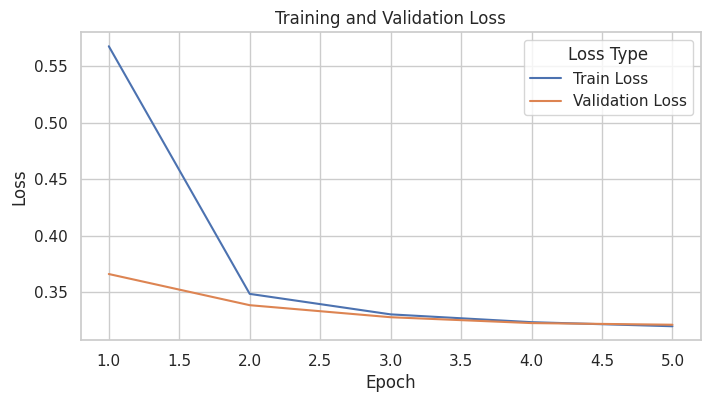

In [51]:
# Create a DataFrame
loss_df = pd.DataFrame({'Epoch': range(1, len(train_loss) + 1),
                        'Train Loss': train_loss,
                        'Validation Loss': val_loss})

# Set Seaborn style
sns.set(style='whitegrid')
plt.figure(figsize=(8, 4))
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(loss_df, ['Epoch']))
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Loss Type', loc='upper right')
plt.show()


In [43]:
#!ls OUTPUT
# !huggingface-cli login
# trainer.push_to_hub()